In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogFormatterSciNotation

from lmfit import Model

/home/gokul/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
sns.set_style('whitegrid')
rcParams['figure.dpi'] = 300
rcParams['figure.figsize'] = (4, 3)
rcParams['grid.linewidth'] = 0.5
rcParams['grid.linestyle'] = 'dashed'
rcParams['legend.fancybox'] = False
rcParams['mathtext.fontset'] = 'stix'
rcParams['xtick.major.pad']='0'
rcParams['ytick.major.pad']='1'

dpi = 150


c6 = ['#c4bae2','#40ada6','#3c4ebf',  
        '#e3a600', '#edb1a3', '#d6543a',]
pretty_palette = [c6[c] for c in range(6) if c in [1,2,3,5]]

In [7]:
merf_df = pd.read_csv('../results/MERFISH_scaling.csv', index_col=0)
cite_df = pd.read_csv('../results/PBMC_CITEseq_scaling.csv', index_col=0)
larry_df = pd.read_csv('../results/LARRY_scaling.csv', index_col=0)

dfs = [merf_df, cite_df, larry_df]

for df in dfs:
    df.replace("RandomProjection", "Rand. proj.", inplace=True)
    df.replace("nanoTxformer", "Txformer", inplace=True)

hue_order = ["VAE", "PCA", "Txformer", "Rand. proj."]

In [4]:
def cell_number_scaling(x, A, B, C):
    return C - (A/x)**B

def info_scaling(x, A, B, C):
    return 0.5 * np.log2((x*B+ 1)/(1+A*x))

In [11]:
d = {
    "Method" : [],
    "Metric" : [],
    "Quality" : [],
    "A" : [],
    "A std err" : [],
    "B" : [],
    "B std err" : [], 
    "C" : [],
    "C std err" : []
}


dfs = [merf_df, larry_df, cite_df, cite_df]

names = ['Spatial MI', 'Clonal MI', 'Protein MI', 'Cell type MI']
mi_keys = ['Spatial neighborhood MI', 'Clonal MI', 'Protein MI', 'Cell type fine MI']


for i, df in enumerate(dfs):
    mi_k = mi_keys[i]
    for method in hue_order:
        for upc in df['UMI per cell'].unique():
            sub_df = df[(df['UMI per cell'] == upc) & (df['Method'] == method)]
            x_data = sub_df['Cell number']
            y_data = sub_df[mi_k]

            model = Model(cell_number_scaling)
            params = model.make_params(A=dict(value=100, min=0), 
                                B=dict(value=1, min=0, max=1),
                                C=dict(value=1, min=0))
            result = model.fit(y_data, params, x=x_data)

            # result.plot_fit()
            # plt.show()

            d['Method'].append(method)
            d['Metric'].append(names[i])
            d['Quality'].append(sub_df['Quality'].unique()[0][1:])
            d['A'].append(result.params['A'].value)
            d['A std err'].append(result.params['A'].stderr)
            d['B'].append(result.params['B'].value)
            d['B std err'].append(result.params['B'].stderr)
            d['C'].append(result.params['C'].value)
            d['C std err'].append(result.params['C'].stderr)

<Axes: xlabel='Quality', ylabel='Metric'>

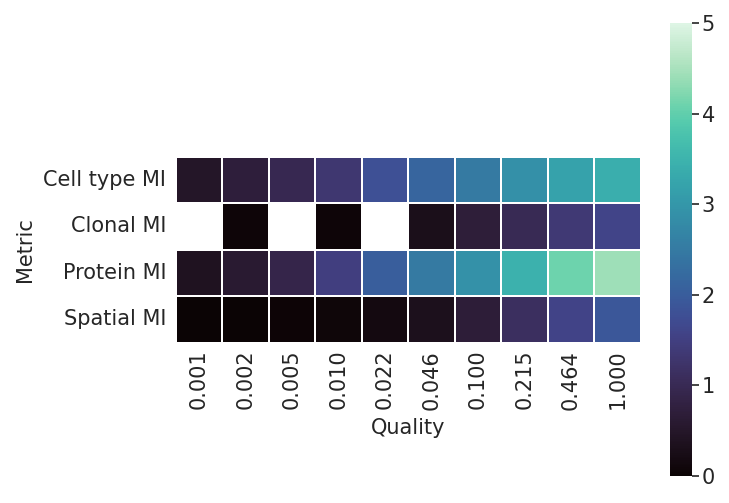

In [12]:
res_df = pd.DataFrame(d)
rcParams['grid.linestyle'] = 'none'
fig = plt.figure(figsize=(5, 4), dpi=dpi)
for row in res_df.iterrows():
    if row[1]['C std err'] > row[1]['C']*0.5 or row[1]['C'] is None:
        res_df.loc[row[0], 'C'] = np.nan

sns.heatmap(res_df[(res_df['Method'] == 'PCA')].pivot(columns='Quality', index='Metric', 
            values='C'), vmax=5, vmin=0, cmap='mako', square=True, lw=0.1)